In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

nltk.download('punkt')

from tqdm import tqdm
import time
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
stop_words = stopwords.words('english')
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold,KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from sklearn import preprocessing, model_selection, pipeline
from sklearn.metrics import f1_score, roc_auc_score
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [86]:
df = pd.read_csv("/content/fake_job_postings.csv")
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [87]:
"""Missing values"""
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [88]:
"""Extracting Text Featurs"""

text_df = df[["title", "company_profile", "description", "requirements", "benefits","fraudulent"]]
text_df = text_df.fillna(' ')

text_df.head()

,title,company_profile,description,requirements,benefits,fraudulent
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0


In [89]:
"""Catagorical Feature"""
cat_df = df[["telecommuting", "has_company_logo", "has_questions", "employment_type", "required_experience", "required_education", "industry", "function","fraudulent"]]
cat_df = cat_df.fillna("None")

cat_df.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,0,1,0,Other,Internship,None,None,Marketing,0
1,0,1,0,Full-time,Not Applicable,None,Marketing and Advertising,Customer Service,0
2,0,1,0,None,None,None,None,None,0
3,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


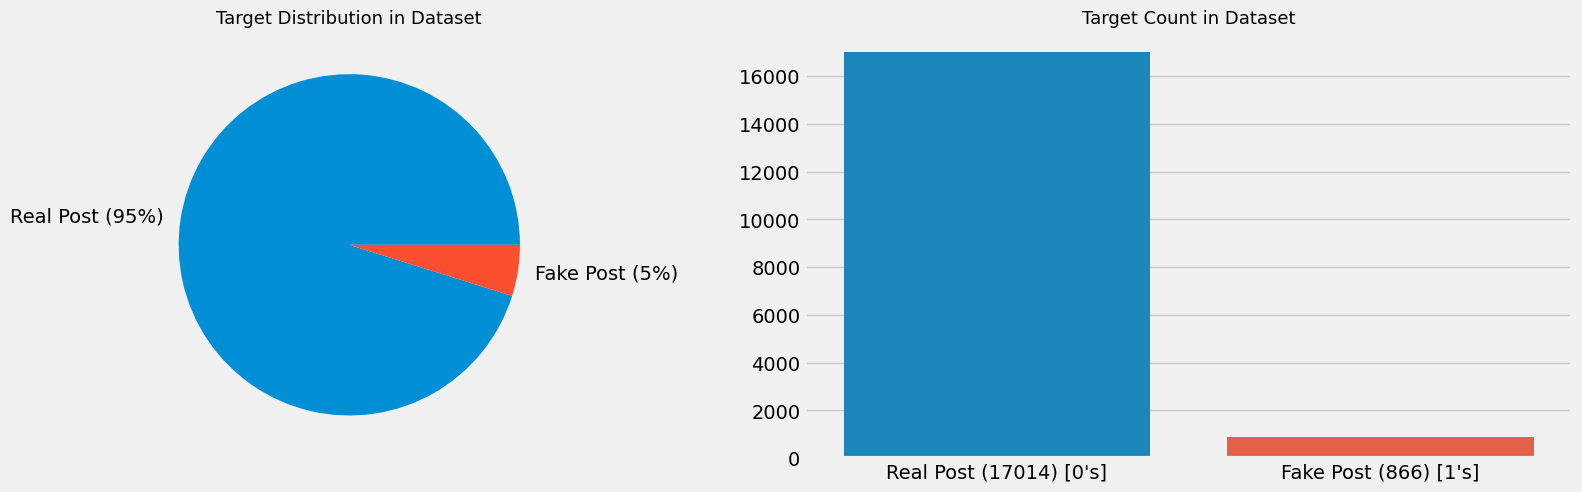

In [90]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
plt.tight_layout()

df["fraudulent"].value_counts().plot(kind='pie', ax=axes[0], labels=['Real Post (95%)', 'Fake Post (5%)'])
temp = df["fraudulent"].value_counts()
sns.barplot(temp.index, temp, ax=axes[1])

axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')
axes[1].set_xticklabels(["Real Post (17014) [0's]", "Fake Post (866) [1's]"])

axes[0].set_title('Target Distribution in Dataset', fontsize=13)
axes[1].set_title('Target Count in Dataset', fontsize=13)

plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


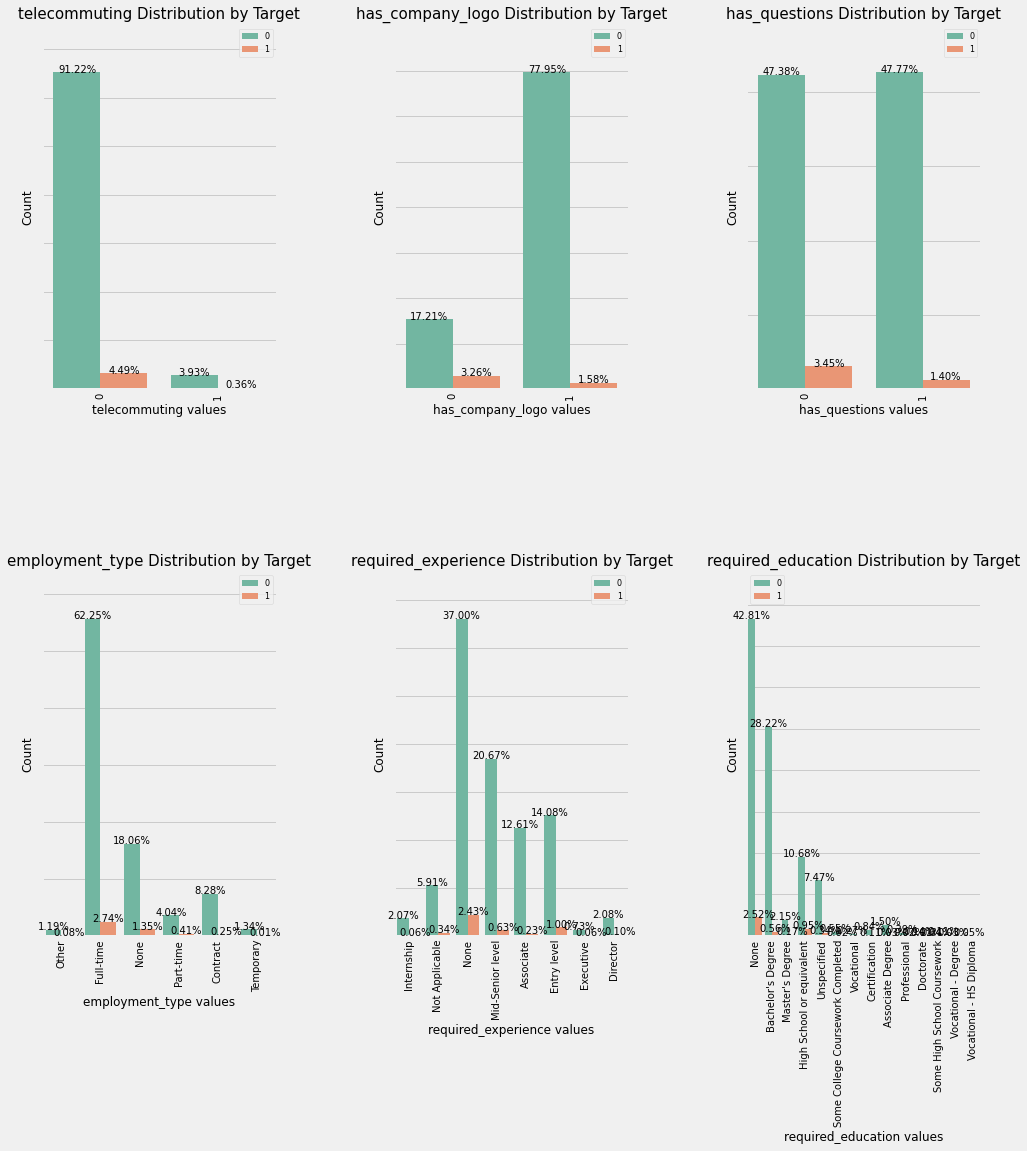

In [91]:
cat_cols = ["telecommuting", "has_company_logo", "has_questions", "employment_type", "required_experience", "required_education",]
# visualizating catagorical variable by target
import matplotlib.gridspec as gridspec # to do the grid of plots
grid = gridspec.GridSpec(3, 3, wspace=0.5, hspace=0.5) # The grid of chart
plt.figure(figsize=(15,25)) # size of figure

# loop to get column and the count of plots
for n, col in enumerate(cat_df[cat_cols]): 
    ax = plt.subplot(grid[n]) # feeding the figure of grid
    sns.countplot(x=col, data=cat_df, hue='fraudulent', palette='Set2') 
    ax.set_ylabel('Count', fontsize=12) # y axis label
    ax.set_title(f'{col} Distribution by Target', fontsize=15) # title label
    ax.set_xlabel(f'{col} values', fontsize=12) # x axis label
    xlabels = ax.get_xticklabels() 
    ylabels = ax.get_yticklabels() 
    ax.set_xticklabels(xlabels,  fontsize=10)
    ax.set_yticklabels(ylabels,  fontsize=10)
    plt.legend(fontsize=8)
    plt.xticks(rotation=90) 
    total = len(cat_df)
    sizes=[] # Get highest values in y
    for p in ax.patches: # loop to all objects
        height = p.get_height()
        sizes.append(height)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=10) 
    ax.set_ylim(0, max(sizes) * 1.15) #set y limit based on highest heights


plt.show()


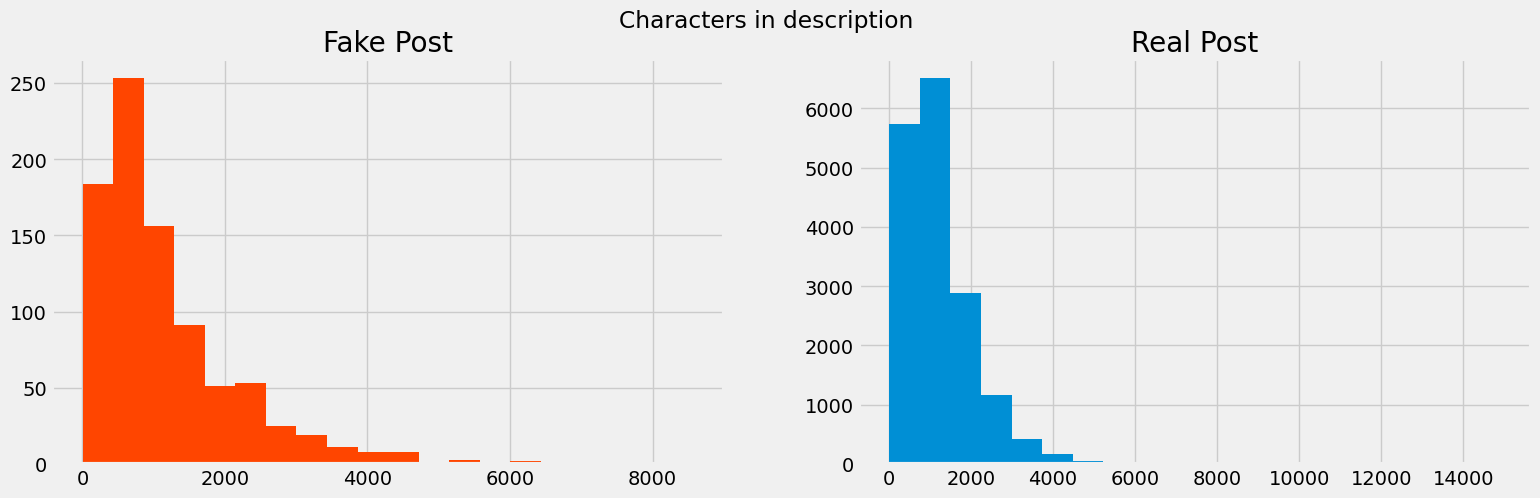

In [92]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
length=text_df[text_df["fraudulent"]==1]['description'].str.len()
ax1.hist(length,bins = 20,color='orangered')
ax1.set_title('Fake Post')
length=text_df[text_df["fraudulent"]==0]['description'].str.len()
ax2.hist(length, bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Characters in description')
plt.show()

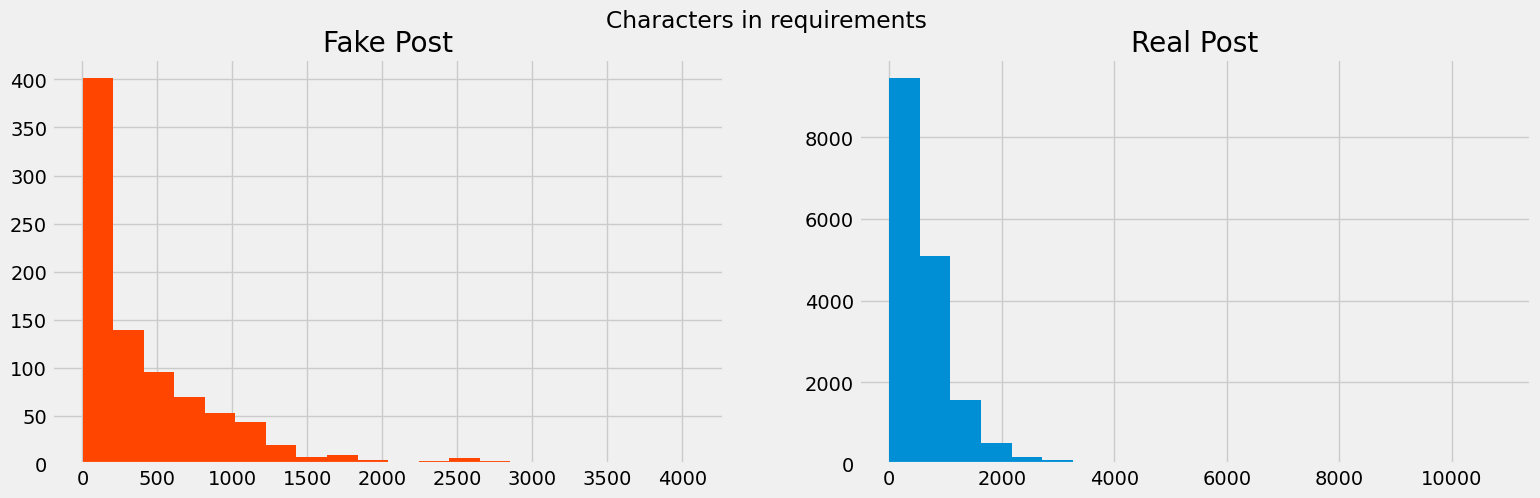

In [93]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
length=text_df[text_df["fraudulent"]==1]['requirements'].str.len()
ax1.hist(length,bins = 20,color='orangered')
ax1.set_title('Fake Post')
length=text_df[text_df["fraudulent"]==0]['requirements'].str.len()
ax2.hist(length,bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Characters in requirements')
plt.show()

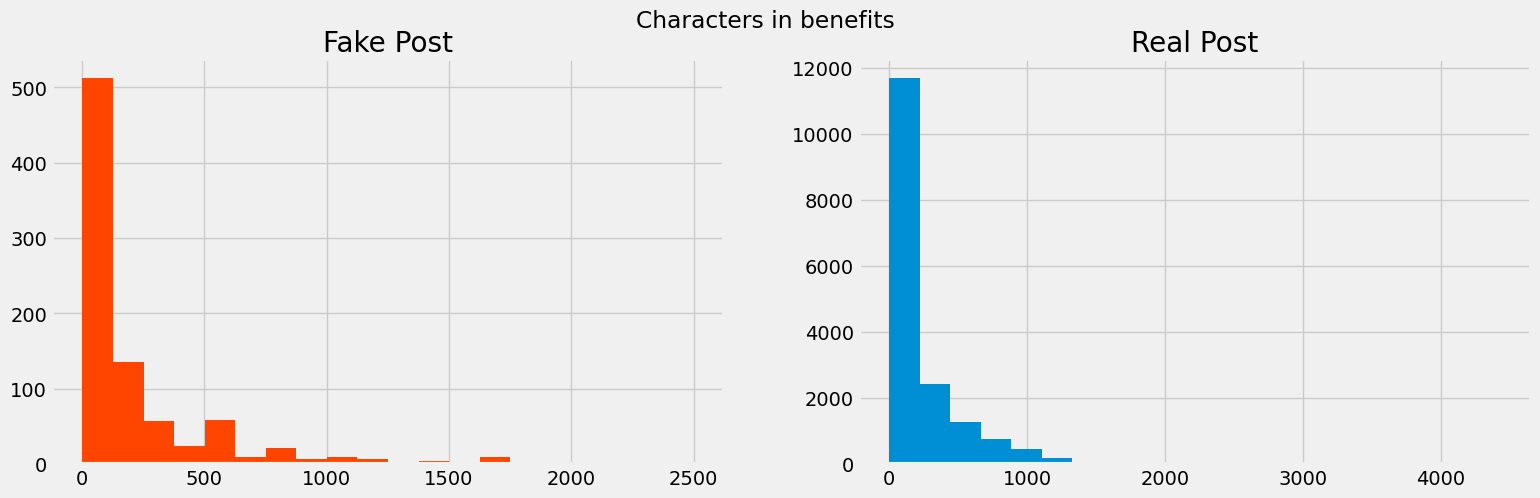

In [94]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
length=text_df[text_df["fraudulent"]==1]['benefits'].str.len()
ax1.hist(length,bins = 20,color='orangered')
ax1.set_title('Fake Post')
length=text_df[text_df["fraudulent"]==0]['benefits'].str.len()
ax2.hist(length,bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Characters in benefits')
plt.show()

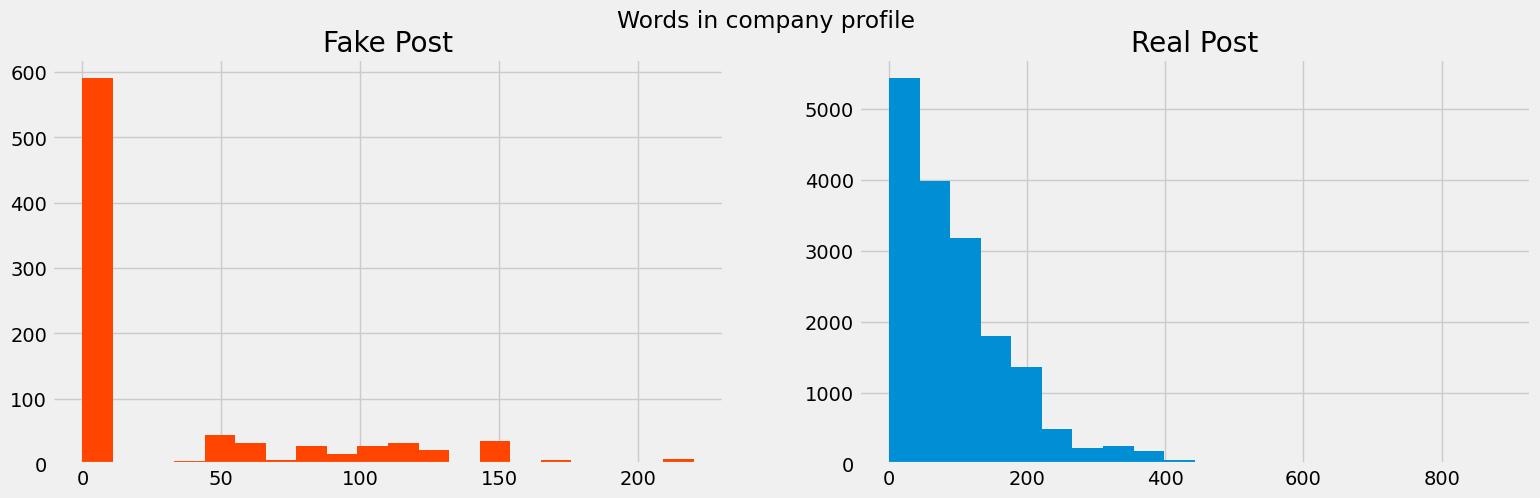

In [95]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
num=text_df[text_df["fraudulent"]==1]['company_profile'].str.split().map(lambda x: len(x))
ax1.hist(num,bins = 20,color='orangered')
ax1.set_title('Fake Post')
num=text_df[text_df["fraudulent"]==0]['company_profile'].str.split().map(lambda x: len(x))
ax2.hist(num, bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Words in company profile')
plt.show()

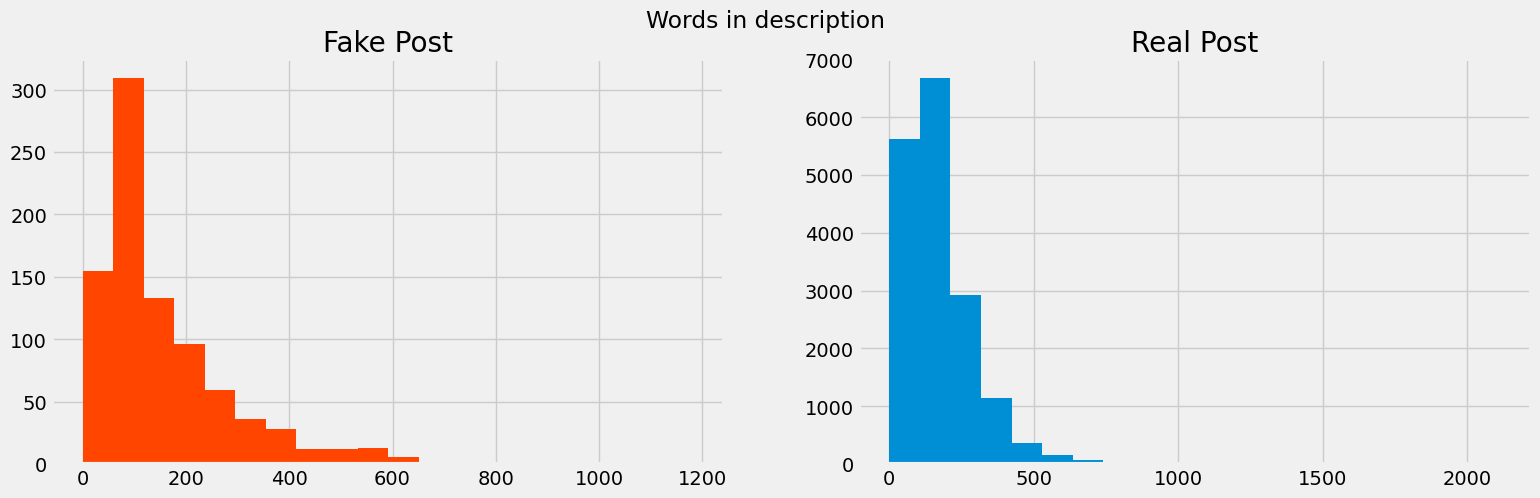

In [96]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
num=text_df[text_df["fraudulent"]==1]['description'].str.split().map(lambda x: len(x))
ax1.hist(num,bins = 20,color='orangered')
ax1.set_title('Fake Post')
num=text_df[text_df["fraudulent"]==0]['description'].str.split().map(lambda x: len(x))
ax2.hist(num, bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Words in description')
plt.show()

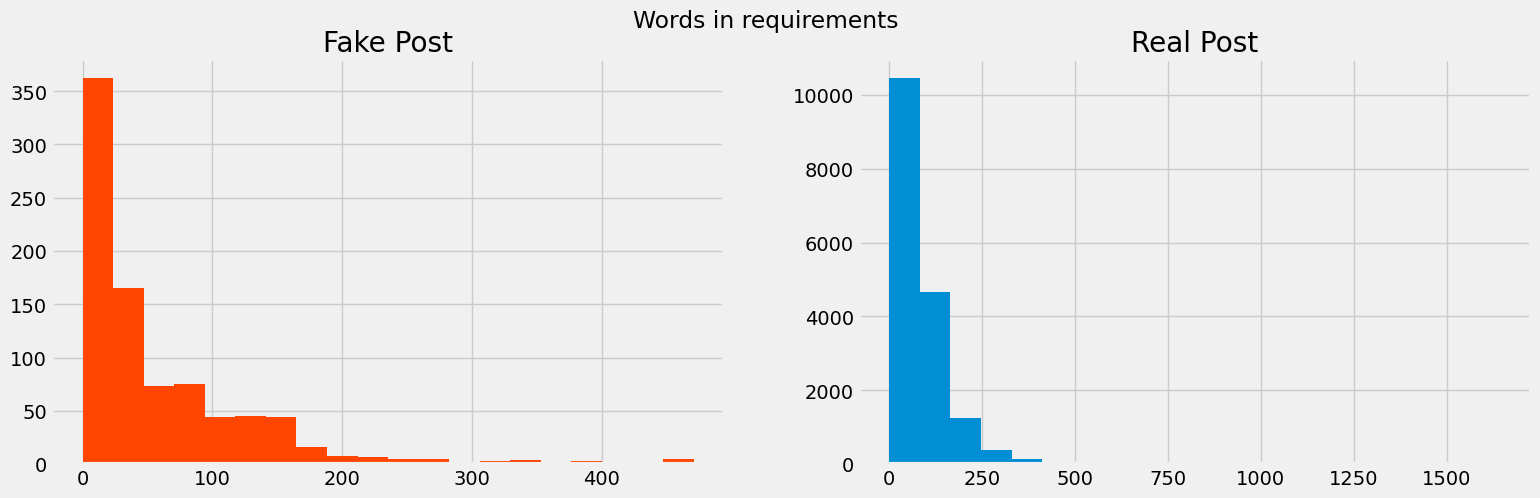

In [97]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
num=text_df[text_df["fraudulent"]==1]['requirements'].str.split().map(lambda x: len(x))
ax1.hist(num,bins = 20,color='orangered')
ax1.set_title('Fake Post')
num=text_df[text_df["fraudulent"]==0]['requirements'].str.split().map(lambda x: len(x))
ax2.hist(num,bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Words in requirements')
plt.show()

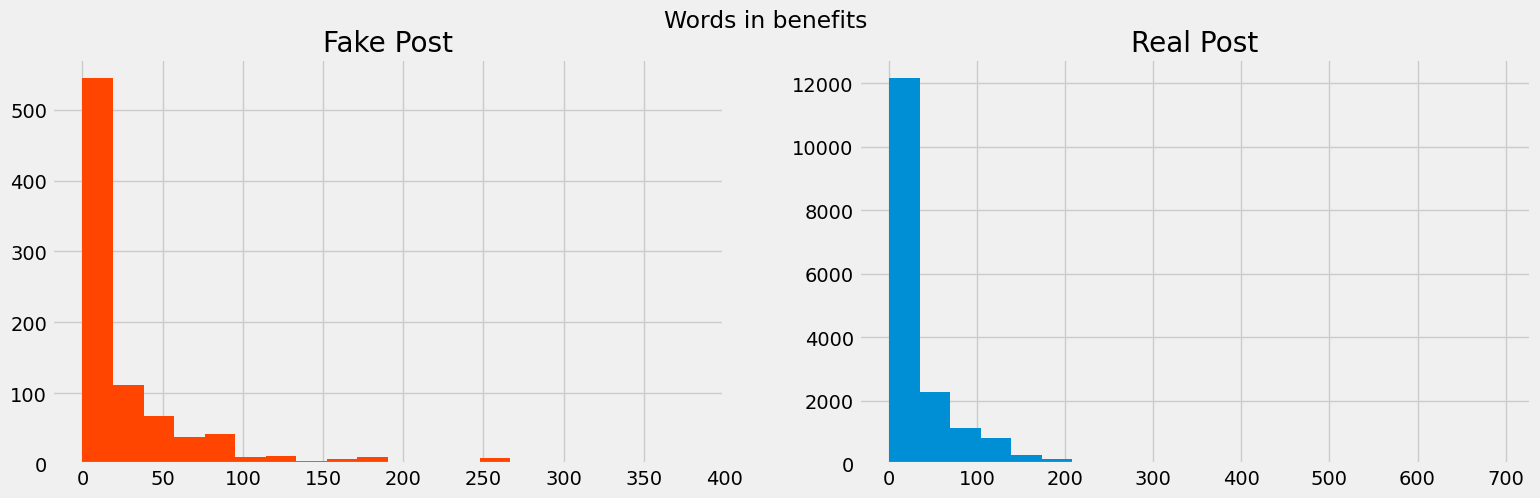

In [98]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
num=text_df[text_df["fraudulent"]==1]['benefits'].str.split().map(lambda x: len(x))
ax1.hist(num,bins = 20,color='orangered')
ax1.set_title('Fake Post')
num=text_df[text_df["fraudulent"]==0]['benefits'].str.split().map(lambda x: len(x))
ax2.hist(num, bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Words in benefits')
plt.show()

In [99]:
text_df_1 = text_df[text_df.columns[0:-1]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
target = df['fraudulent']

print(len(text_df_1))
print(len(target))

17880
17880


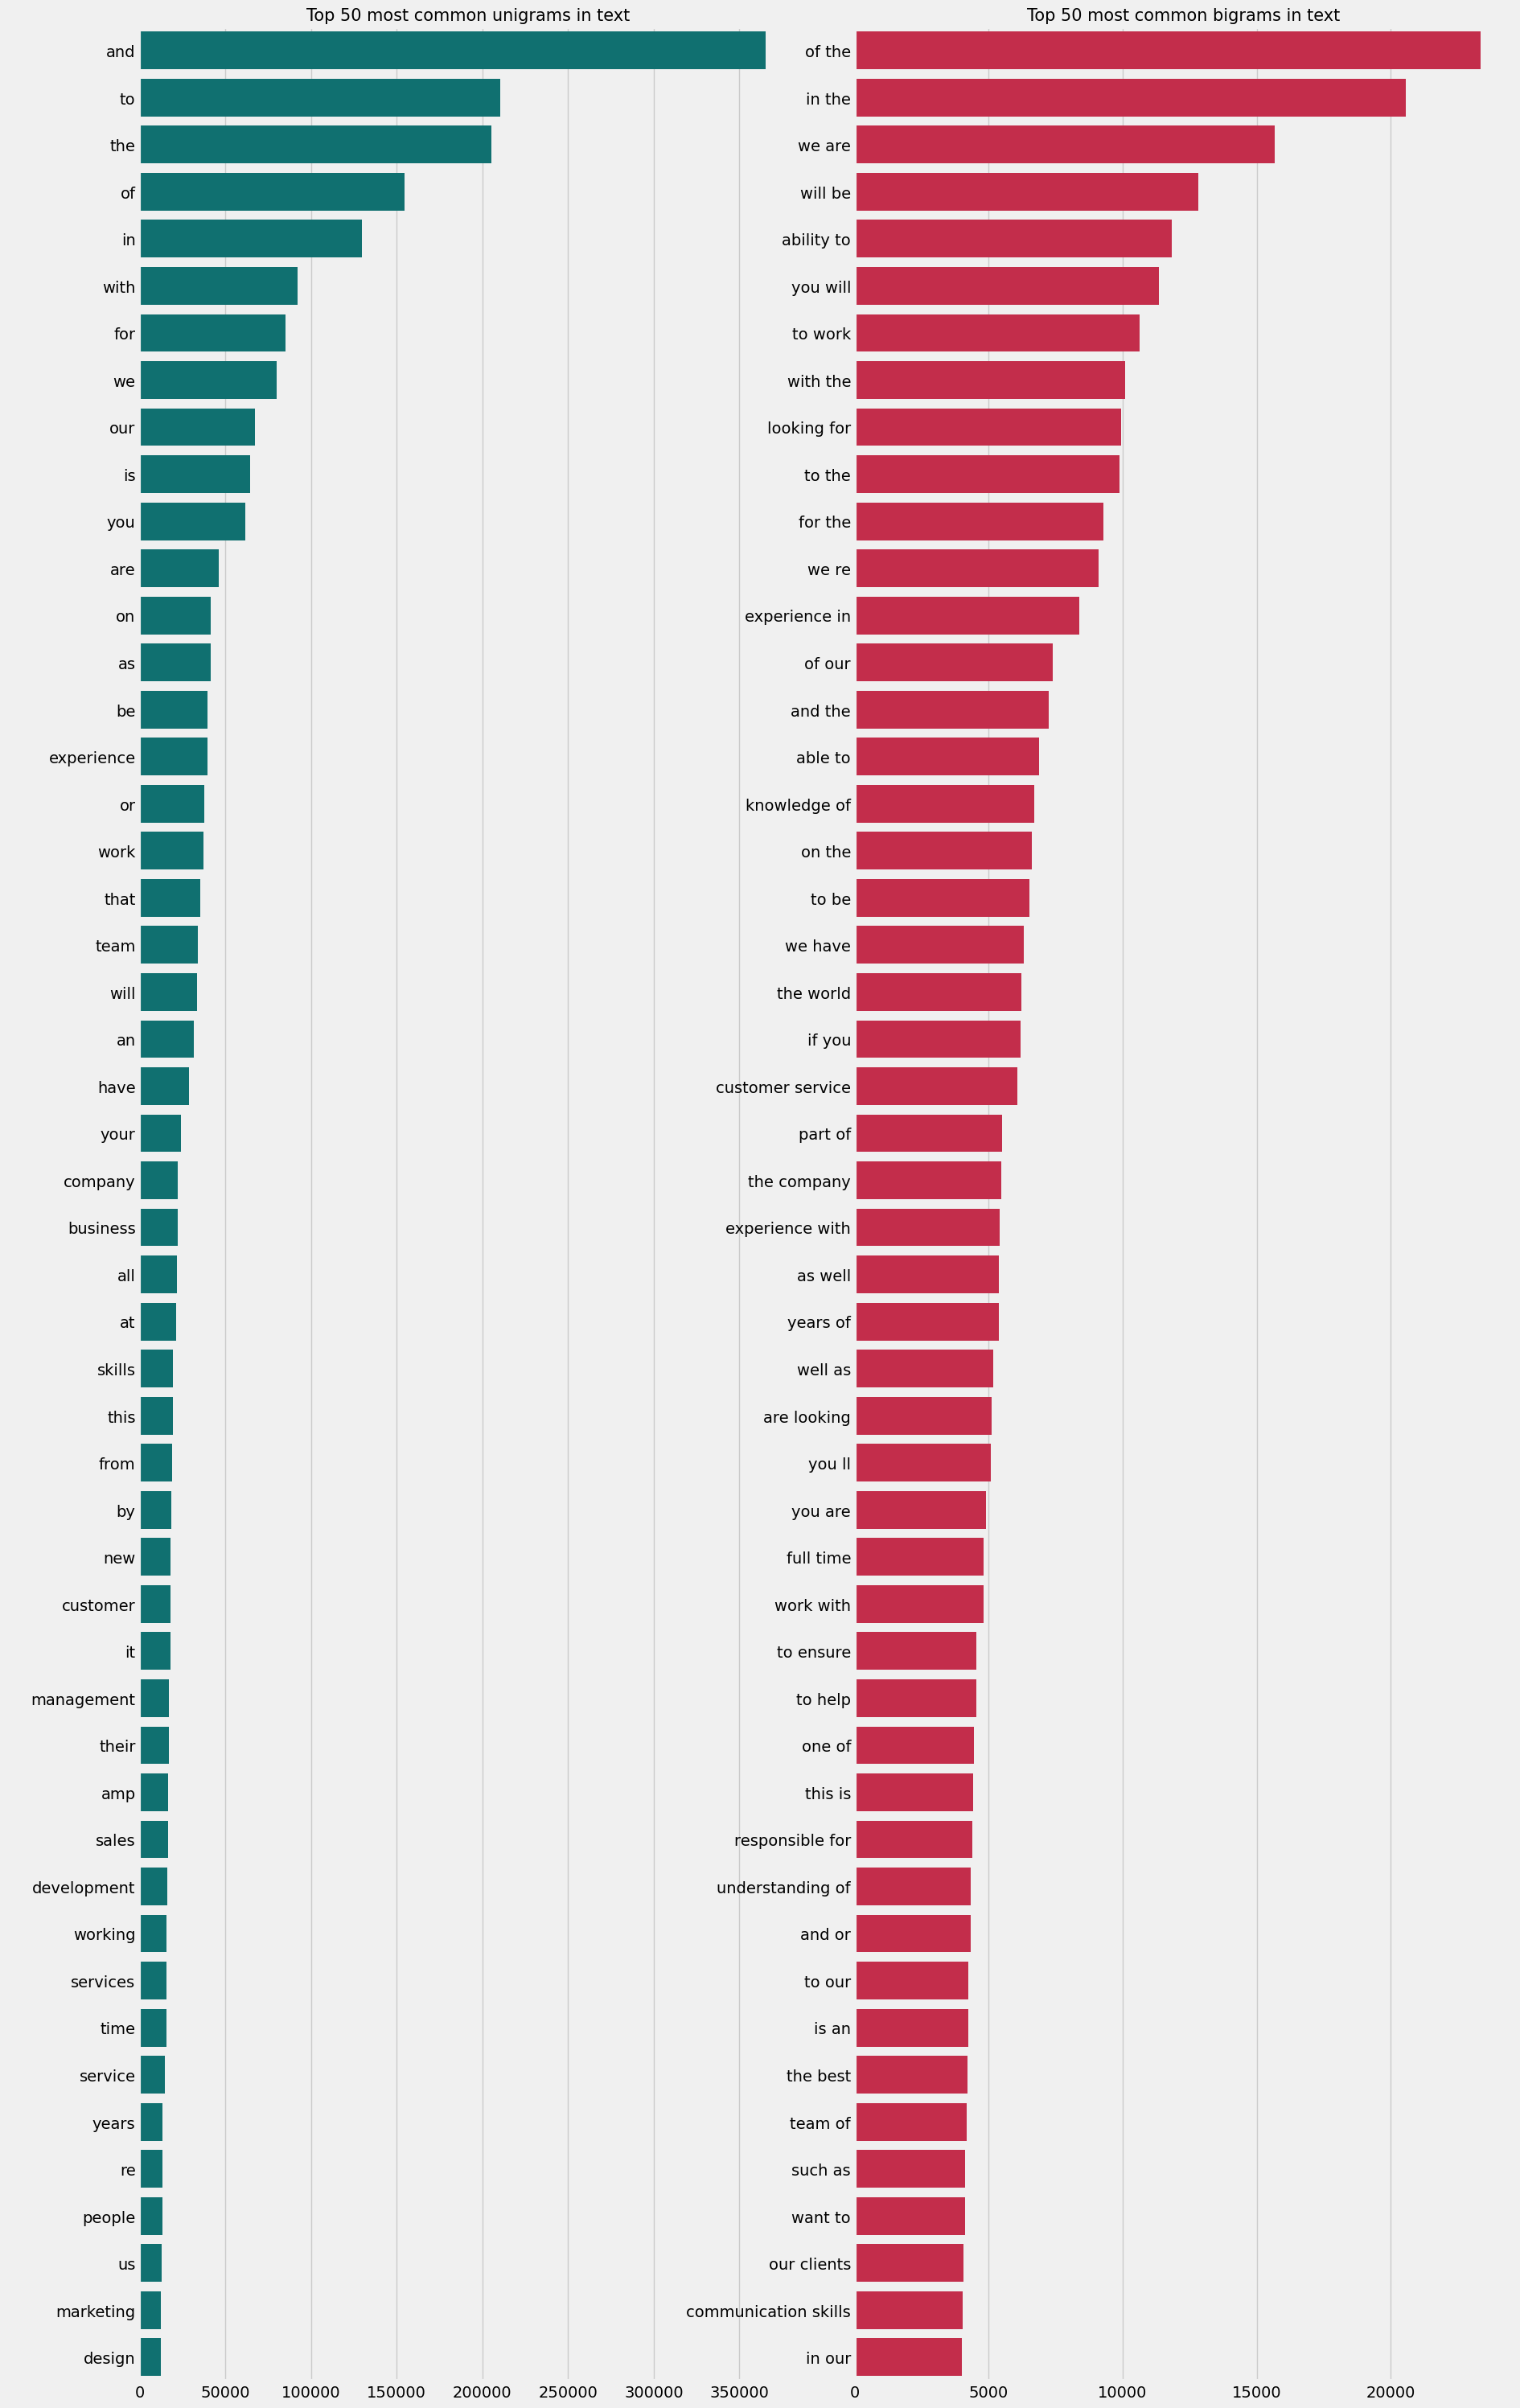

In [100]:
def get_top_tweet_unigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1, 1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

fig, axes = plt.subplots(ncols=2, figsize=(18, 30), dpi=100)
plt.tight_layout()

top_unigrams=get_top_tweet_unigrams(text_df_1)[:50]
x,y=map(list,zip(*top_unigrams))
sns.barplot(x=y,y=x, ax=axes[0], color='teal')


top_bigrams=get_top_tweet_bigrams(text_df_1)[:50]
x,y=map(list,zip(*top_bigrams))
sns.barplot(x=y,y=x, ax=axes[1], color='crimson')


axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')

axes[0].set_title('Top 50 most common unigrams in text', fontsize=15)
axes[1].set_title('Top 50 most common bigrams in text', fontsize=15)

plt.show()


In [101]:
def clean_text_df_1(text_df_2):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text_df_2 = text_df_2.lower()
    text_df_2 = re.sub('\[.*?\]', '', text_df_2)
    text_df_2 = re.sub('https?://\S+|www\.\S+', '', text_df_2)
    text_df_2 = re.sub('<.*?>+', '', text_df_2)
    text_df_2 = re.sub('[%s]' % re.escape(string.punctuation), '', text_df_2)
    text_df_2 = re.sub('\n', '', text_df_2)
    text_df_2 = re.sub('\w*\d\w*', '', text_df_2)
    return text_df_2


# Applying the cleaning function to both test and training datasets
text_df_1 = text_df_1.apply(lambda x: clean_text_df_1(x))
text_df_1.head(3)

0    marketing internwere  and weve created a groun...
1    customer service  cloud video  seconds the wor...
2    commissioning machinery assistant cmavalor ser...
dtype: object

In [102]:
%%time
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

# appling tokenizer5
text_df_1 = text_df_1.apply(lambda x: tokenizer.tokenize(x))
text_df_1.head(3)

CPU times: user 1.38 s, sys: 156 ms, total: 1.54 s
Wall time: 1.54 s


In [103]:
%%time
def remove_stopwords(text):
    """
    Removing stopwords belonging to english language
    
    """
    words = [w for w in text if w not in stop_words]
    return words


text_df_1 = text_df_1.apply(lambda x : remove_stopwords(x))

CPU times: user 9.54 s, sys: 14.1 ms, total: 9.55 s
Wall time: 9.56 s


In [104]:
%%time
def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text

text_df_1 = text_df_1.apply(lambda x : combine_text(x))
text_df_1.head(3)

CPU times: user 189 ms, sys: 23.1 ms, total: 212 ms
Wall time: 216 ms


In [105]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
auc_buf = []   
cnt = 0
predictions = 0
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(text_df_1, target):
    print('Fold {}'.format(cnt + 1))
    train_X, test_X = text_df_1[train_ix], text_df_1[test_ix]
    train_y, test_y = target[train_ix], target[test_ix]

    # Appling Count Vectorizer
    count_vectorizer = CountVectorizer()
    train_X_vec = count_vectorizer.fit_transform(train_X)
    test_X_vec = count_vectorizer.transform(test_X)    
    
    lr = LogisticRegression(C=0.1, solver='lbfgs', max_iter=1000, verbose=0, n_jobs=-1)
    lr.fit(train_X_vec, train_y)
    preds = lr.predict(test_X_vec)
    
    auc = roc_auc_score(test_y, preds)
    print('{} AUC: {}'.format(cnt, auc))
    auc_buf.append(auc)
    cnt += 1

print('AUC mean score = {:.6f}'.format(np.mean(auc_buf)))
print('AUC std score = {:.6f}'.format(np.std(auc_buf)))


Fold 1
0 AUC: 0.8486824783980131
Fold 2
1 AUC: 0.8517195809885532
Fold 3
2 AUC: 0.8342316113459901
Fold 4
3 AUC: 0.8720977240415205
Fold 5
4 AUC: 0.8611871313020738
AUC mean score = 0.853584
AUC std score = 0.012670


In [109]:
# spliting tthe data for glove
X_train, X_test, y_train, y_test = train_test_split(text_df_1, target, test_size=0.2, random_state=4, stratify=target)
"""Load the Glove vectors in a dictionay"""
embeddings_index={}
with open('/content/glove.6B.200d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embeddings_index[word]=vectors
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 374611 word vectors.


In [112]:
""" Function Creates a normalized vector for the whole sentence"""
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(200)
    return v / np.sqrt((v ** 2).sum())
xtrain_glove = np.array([sent2vec(x) for x in tqdm(X_train)])
xtest_glove = np.array([sent2vec(x) for x in tqdm(X_test)])


100%|██████████| 14304/14304 [00:31<00:00, 457.11it/s]

100%|██████████| 3576/3576 [00:07<00:00, 453.55it/s]


In [113]:
"""scale the data before any neural net"""
scl = preprocessing.StandardScaler()
xtrain_glove_scl = scl.fit_transform(xtrain_glove)
xtest_glove_scl = scl.transform(xtest_glove)
"""create a simple 2 layer sequential neural net"""
model = Sequential()

model.add(Dense(200, input_dim=200, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(1))
model.add(Activation('sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(xtrain_glove_scl, y=y_train, batch_size=64, 
          epochs=10, verbose=1, 
          validation_data=(xtest_glove_scl, y_test))

Train on 14304 samples, validate on 3576 samples
Epoch 1/10
14304/14304 [==============================] - 2s 112us/step - loss: 0.3981 - accuracy: 0.8349 - val_loss: 0.1390 - val_accuracy: 0.9639
Epoch 2/10
14304/14304 [==============================] - 1s 62us/step - loss: 0.1475 - accuracy: 0.9581 - val_loss: 0.1098 - val_accuracy: 0.9709
Epoch 3/10
14304/14304 [==============================] - 1s 60us/step - loss: 0.1180 - accuracy: 0.9637 - val_loss: 0.0971 - val_accuracy: 0.9734
Epoch 4/10
14304/14304 [==============================] - 1s 60us/step - loss: 0.1019 - accuracy: 0.9688 - val_loss: 0.0952 - val_accuracy: 0.9734
Epoch 5/10
14304/14304 [==============================] - 1s 60us/step - loss: 0.0881 - accuracy: 0.9709 - val_loss: 0.0884 - val_accuracy: 0.9732
Epoch 6/10
14304/14304 [==============================] - 1s 56us/step - loss: 0.0809 - accuracy: 0.9722 - val_loss: 0.0903 - val_accuracy: 0.9751
Epoch 7/10
14304/14304 [==============================] - 1s 55us/st

In [114]:
predictions = model.predict(xtest_glove_scl)
predictions = np.round(predictions).astype(int)
print('2 layer sequential neural net on GloVe Feature')
print ("AUC score :", np.round(roc_auc_score(y_test, predictions),5))

2 layer sequential neural net on GloVe Feature
AUC score : 0.84834


In [116]:
new_text = text_df[text_df.columns[0:-1]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
target = df['fraudulent']
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


# Applying the cleaning function to both test and training datasets
new_text = new_text.apply(lambda x: clean_text(x))
new_text.head(3)

0    marketing internwere  and weve created a groun...
1    customer service  cloud video  seconds the wor...
2    commissioning machinery assistant cmavalor ser...
dtype: object

In [117]:
# Trying First 2000 sample
batch_1 = new_text[:2000]
target_1 = target[:2000]
target_1.value_counts()

0    1948
1      52
Name: fraudulent, dtype: int64

In [127]:
!pip install -q transformers

# importing the tools 
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
# DistilBERT
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

     |████████████████████████████████| 573kB 2.8MB/s 
     |████████████████████████████████| 1.0MB 13.3MB/s 
     |████████████████████████████████| 890kB 20.8MB/s 
     |████████████████████████████████| 3.7MB 20.8MB/s 


In [128]:
%%time
# Tokenization
tokenized = batch_1.apply((lambda x: tokenizer.encode(x, max_length = 60, add_special_tokens=True)))
tokenized.shape

CPU times: user 17.5 s, sys: 14.2 ms, total: 17.5 s
Wall time: 17.5 s


In [129]:
# Padding ==> convert 1D array to 2D array
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
np.array(padded).shape

(2000, 60)

In [130]:
# Masking ==>  ignore (mask) the padding we've added
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2000, 60)

In [131]:
# Deep Learning
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

last_hidden_states[0].shape

torch.Size([2000, 60, 768])

In [132]:
features = last_hidden_states[0][:,0,:].numpy()
labels = target_1
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)
# train default para
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [133]:
predictions = lr_clf.predict(test_features)
predictions = np.round(predictions).astype(int)
print ("AUC score :", np.round(roc_auc_score(test_labels, predictions),5))


AUC score : 0.8
